In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats, optimize, interpolate
from scipy.integrate import odeint
from scipy.integrate import solve_bvp
plt.rcParams.update({'font.size': 18})

In [2]:
#
# Define function cvi_sim which computes resulting pore radius/gas concentration profiles as a function of CVI process parameters
#



def cvi_sim(Tin,Pin, phi0in, rin, ain,plot_line_color,plot_line_label,dt,variable_plotted): # Temperature, pressure, initial pore diameter, aspect ratio, phase ratio, line color, line label, time stepper, variable to plot (between rp and C). 
    phi0 = phi0in     # Pore diameter, m
    rp0 = phi0/2      # Pore radius, m    
    L = rin*phi0      # Length, m
    nz = 1000         # Number of grid points, dimensionless
    h = L/(nz+1)      # Distance between grid points, m
    print(h)
    dt = dt           # Time stepper, s
    
    Zrange = np.linspace(0,L,nz)           # Grid that represents length of specimen
    alpha = ain                            # Ratio between H2 and MTS concentrations at reactor entrance, dimensionless
    P = Pin                                # Pressure, Pa
    T = Tin                                # Temperature, K
    R = 8.314                              # Ideal gas constant, J/mol K
    
    CMTS0 = (1/(1+alpha))*(P / (R*T))      # MTS concentration at z=0 (BC), mol/m^3
    CH20 = (alpha/(1+alpha))*(P / (R*T))   # H2 concentration at z=0 (1-CMTS0), mol/m^3,  Fedou1993-2 Eqs. 9-10
    CHCl0 = 0                              # HCl concentration at z=0 (1-CMTS0), mol/m^3
    
    k0 = 3.89e9                            # Reaction rate coefficient, m/s
    Ea = 296e3                             # Activation energy, J/mol
    
    CMTS = np.zeros(nz)
    CMTS[0] = CMTS0
    CH2 = np.zeros(nz)                     # Gas phase composition at pore entrance, Fedou1993-2 Eqs. 9-10
    CH2[0] = CH20
    CHCl = np.zeros(nz)
    CHCl[0] = CHCl0

    k_het = k0*np.exp(-Ea/(R*T))           # Kinetic law, Fedou1993-2 Eq. 3
    nu = k_het*CMTS
    
    dKMTS = 3.97 #m/sK^(1/2)               # Reduced Knudsen coefficient of MTS, m/s K^1/2
    dKH2 = 34.30 #m/sK^(1/2)               # Reduced Knudsen coefficient of H2, m/s K^1/2,  Fedou1993-2 Table I
    dKHCl = 8.03 #m/sK^(1/2)               # Reduced Knudsen coefficient of HCl, m/s K^1/2
    
    DKMTS=dKMTS*phi0*(T**0.5)              # Knudsen diffusion coefficient of MTS, m^2/s 
    DKH2=dKH2*phi0*(T**0.5)                # Knudsen diffusion coefficient of H2, m^2/s,  Fedou1993-2 Eq. 2
    DKHCl=dKHCl*phi0*(T**0.5)              # Knudsen diffusion coefficient of HCl, m^2/s 
    
    # MSiC = 0.04011                       # Molar mass of SiC, kg/mol
    MMTS=0.149                             # Molar mass of MTS, kg/mol
    MH2 = 2e-3                             # Molar mass of H2, kg/mol,  Fedou1993-2 Table I
    MHCl = 3.65e-2                         # Molar mass of HCl, kg/mol
    
    # rhoSiC = 3217                          # Density of SiC, kg/m^3
    # rhoMTS = 1270
    # rhoH2 = 0.08375
    # rhoHCl = 1048
    
    VSiC = 1.25e-5                         # Specific volume of SiC, m^3/mol,  Fedou1993-2 Section 2.2
    VMTS=1.227e-4                          # Specific volume of MTS, m^3/mol
    VH2=1.43e-5                            # Specific volume of H2, m^3/mol,  Fedou1993-2 Table III
    VHCl= 25.3e-5                          # Specific volume of HCl, m^3/mol
    deltaV = VMTS + VH2 + VHCl
    
    Dij_MTSH2 = 1.360e-3*((T**(3/2))/(P*(VH2**(1/3)+VMTS**(1/3))**2))*(1/MH2 + 1/MMTS)**0.5 
    Dij_MTSHCl = 1.360e-3*((T**(3/2))/(P*(VHCl**(1/3)+VMTS**(1/3))**2))*(1/MHCl + 1/MMTS)**0.5   # Gilliland formula, Fedou1993-1 Appendix 1 Eq A4
    Dij_H2HCl = 1.360e-3*((T**(3/2))/(P*(VHCl**(1/3)+VH2**(1/3))**2))*(1/MHCl + 1/MH2)**0.5 
    
    xMTS  = CMTS0/(CMTS0+CH20+CHCl0)
    xH2 = CH20/(CMTS0+CH20+CHCl0)                          # Molar fractions, Fedou1993-1 Eq. 13
    xHCl = CHCl0/(CMTS0+CH20+CHCl0)
    
    dxMTSdz = dxH2dz = dxHCldz = np.zeros(nz)
    # dxMTSdz[:-1] = (xMTS[1:] - xMTS[:-1])/h                         
    # dxMTSdz[-1] = dxMTSdz[-2]
    # dxH2dz[:-1] = (xH2[1:] - xH2[:-1])/h                            # Molar fractions slope
    # dxH2dz[-1] = dxH2dz[-2]
    # dxHCldz[:-1] = (xHCl[1:] - xHCl[:-1])/h                         
    # dxHCldz[-1] = dxHCldz[-2]
    
    DFMTS = ((1/(1-xMTS))*(xHCl/Dij_MTSHCl + xH2/Dij_MTSH2))**(-1)
    DFH2 = ((1/(1-xH2))*(xHCl/Dij_H2HCl + xMTS/Dij_MTSH2))**(-1)     # Fick diffusion coefficients, Fedou1993-1 Eq. 16
    DFHCl = ((1/(1-xHCl))*(xH2/Dij_H2HCl + xMTS/Dij_MTSHCl))**(-1)

    DMTS = (1/DFMTS + 1/DKMTS)**(-1)          
    DH2 = (1/DFH2 + 1/DKH2)**(-1)            # Overall diffusion coefficient, Fedou1993-1 Eq. 15
    DHCl = (1/DFHCl + 1/DKHCl)**(-1)              


    print('k_het =',k_het,'T=',T,'P=',P, 'CMTS0=',CMTS0,'CH20=',CH20,'CHCl0=',CHCl0)

    rpi = rp0*np.ones(nz)                  # Pore radius at t=0 (IC), m
    rp = rpi
    drpdzi = np.zeros(nz)                  # drp/dz at t=0 (IC), m
    drpdz = drpdzi

    C = []
    
    CMTSt = []                             
    CH2t = []                              # Array containing gas concentration profiles of MTS, H2, HCl
    CHClt = []
    
    rpt = []                               # Array containing pore radius profiles over time

    detA = None                            # Initialization of variable representing the determinant of system matrix
    percent_closed = 0                     # Dimensionless rating of pore size relative to initial pore size
    n = 0                                  # Loop counter
    
    rows, cols = (nz, nz)
    arr = [[0 for i in range(cols)] for j in range(rows)]   # Initializing the system matrix A
    A = np.array(arr)                                       
    for i in range(rows):
        for j in range(cols):
            if j==i:
                A[i][j] = 2
                if not i==0:
                    # print(A1zi)
                    A[i][j-1] = -1
                if not j==cols-1:
                    A[i][j+1] = -1
                else:
                    A[i][j] = 2 - 1                 # boundary condition: C(n+1)=C(n) ==> A3(z_n)C(n+1) + A2(z_n)C_n + A1(z_n)C(n-1) = 0 --> (A3(z_n)+A2(z_n))C_n + A1(z_n)C(n-1) = 0

    print(A)
    
    m = 0                                  # Loop counter
    while (any(rp<rp0/100) is not True) and (percent_closed < 98):# and (detA != 0):
        
        Dm = np.array([DMTS, DH2, DHCl])                # Array of diffusion coefficients
        C0m = np.array([CMTS0, CH20, CHCl0])            # Array of interfacial boundary conditions
        xm = np.array([xMTS, xH2, xHCl])               # Array of molar fractions
        dxdzm = np.array([dxMTSdz, dxH2dz, dxHCldz])   # Array of molar fraction slopes
        Vm = np.array([VMTS, VH2, VHCl])   # Array of molar volumes

        for m in range(3):                                  # Calculating gas concentration profiles for each of MTS, H2, HCl (3 gases)
            
            fm = ((nu*(h**2))/(Dm[m]))*(((2*xm[m]*deltaV)/rp)+deltaV*dxdzm[m] - ((2*Vm[m])/rp))   # Initialize f in AC = f
            fm[0] += C0m[m]                                        # boundary condition: A3(z_1)C(2) + A2(z_1)C(1) + A1(z_1)C(0) = 0 --> A3(z_1)C(2) + A2(z_1)C(1) = -A1z1*CMTS0
            # if n==0 and m==0:
            #     print(nu[0:2], h**2, Dm[m][0])
            #     print(fm)
            detA = np.linalg.det(A)
            Cm = np.linalg.solve(A, fm)                            # Solve for gas concentration profile C in AC = f
            
            C.append(Cm)                                            # Store profile of gas m
            m+=1
        
        CMTS = C[0]
        CH2 = C[1]
        CHCl = C[2]
        
        xMTS = CMTS/(CMTS+CH2+CHCl)
        xH2 = CH2/(CMTS+CH2+CHCl)          # Update molar fractions, Fedou1993-1 Eq. 12
        xHCl = CHCl/(CMTS+CH2+CHCl)
        
        dxMTSdz[:-1] = (xMTS[1:] - xMTS[:-1])/h                         
        dxMTSdz[-1] = dxMTSdz[-2]
        dxH2dz[:-1] = (xH2[1:] - xH2[:-1])/h                            # Update molar fractions slope
        dxH2dz[-1] = dxH2dz[-2]
        dxHCldz[:-1] = (xHCl[1:] - xHCl[:-1])/h                         
        dxHCldz[-1] = dxHCldz[-2]

        DFMTS = ((1/(1-xMTS))*(xHCl/Dij_MTSHCl + xH2/Dij_MTSH2))**(-1)
        DFH2 = ((1/(1-xH2))*(xHCl/Dij_H2HCl + xMTS/Dij_MTSH2))**(-1)     # Update Fick diffusion coefficients, Fedou1993-1 Eq. 16
        DFHCl = ((1/(1-xHCl))*(xH2/Dij_H2HCl + xMTS/Dij_MTSHCl))**(-1)

        DMTS = (1/DFMTS + 1/DKMTS)**(-1)          
        DH2 = (1/DFH2 + 1/DKH2)**(-1)            # Update overall diffusion coefficient, Fedou1993-1 Eq. 15
        DHCl = (1/DFHCl + 1/DKHCl)**(-1)              
        
        nu = k_het*CMTS                                           # Kinetic law, Eq. 3 in Fedou1993
        rp = rp*(1-dt*nu*VSiC)                                    # Update pore radius 
        drpdz[:-1] = (rp[1:] - rp[:-1])/h                         # Update pore radius slope
        drpdz[-1] = drpdz[-2]

        C = []                                                    # Reset vector containing gas concentration profiles at current time step
        m = 0
        n+=1
        if n % 10 == 0:
            CMTSt.append(CMTS)
            CH2t.append(CH2)
            CHClt.append(CHCl)
            rpt.append(rp)                                        # Collect pore radius/gas concentration profiles at current time step
            percent_closed = 100*(1 -(rp[0]-rp0/100)/rp0)
            print('n=',n,': detA = ',round(detA,10),', pore is', round(percent_closed,2),'% closed')
            #print('n=',n,': at t =',round(n*dt*0.000277778/100,2),'hours, pore is', round(percent_closed,2),'% closed')
    print(n)
    
#
# Post processing
#
    
    plotlabel = str(plot_line_label)
    plot_line_color = str(plot_line_color)
    if variable_plotted == "rp":
        if plotlabel == "none" or plotlabel == "":
            plt.plot(Zrange,(rp0-rp),linewidth=2,color=plot_line_color)
        else:
            plt.plot(Zrange,(rp0-rp),label=plotlabel,linewidth=2,color=plot_line_color)
        lines = str(rp0-rp)
        with open('rp_'+'T'+str(T)+'_P'+str(P)+'_phi0'+str(round(phi0*1e6,2))+'_ar'+str(round(L/phi0,2))+'.txt', 'w') as f:
            f.writelines(lines)
        plt.xlabel(r'Infiltration depth (mm)')
        plt.ylabel(r'SiC deposition ($\mu$m)')
        plt.xlim([0,L/2])
        plt.ylim([0,rp0])
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
        plt.savefig('rp_'+'T'+str(T)+'_P'+str(P)+'_phi0'+str(round(phi0*1e6,2))+'_ar'+str(round(L/phi0,2))+'.png', dpi=220,bbox_inches='tight')

    if variable_plotted == "C":
        if plotlabel == "none" or plotlabel == "":
            plt.plot(Zrange,CMTS,label='MTS',linewidth=2,color=plot_line_color)
            plt.plot(Zrange,CH2,label='H2',linewidth=2,color='c')
            plt.plot(Zrange,CHCl,label='HCl',linewidth=2,color='g')
        else:
            plt.plot(Zrange,CMTS,label=plotlabel+', MTS',linewidth=2,color=plot_line_color)
            plt.plot(Zrange,CH2,label=plotlabel+', H2',linewidth=2,color='c')
            plt.plot(Zrange,CHCl,label=plotlabel+', HCl',linewidth=2,color='g')
        lines = str(C)
        with open('C_'+'T'+str(T)+'_P'+str(P)+'_phi0'+str(round(phi0*1e6,2))+'_ar'+str(round(L/phi0,2))+'.txt', 'w') as f:
            f.writelines(lines)
        plt.xlabel(r'Infiltration depth (mm)')
        plt.ylabel(r'Gas concentration (mol/m$^3$)')
        plt.xlim([0,L/2])
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
        plt.savefig('C_'+'T'+str(T)+'_P'+str(P)+'_phi0'+str(round(phi0*1e6,2))+'_ar'+str(round(L/phi0,2))+'.png', dpi=220,bbox_inches='tight')


9.99000999000999e-06
k_het = 0.0027786172881957174 T= 1273 P= 20000 CMTS0= 0.1717903983288505 CH20= 1.717903983288505 CHCl0= 0
[[ 2 -1  0 ...  0  0  0]
 [-1  2 -1 ...  0  0  0]
 [ 0 -1  2 ...  0  0  0]
 ...
 [ 0  0  0 ...  2 -1  0]
 [ 0  0  0 ... -1  2 -1]
 [ 0  0  0 ...  0 -1  1]]
n= 10 : detA =  1.0 , pore is 46.95 % closed
n= 20 : detA =  1.0 , pore is 71.78 % closed
n= 30 : detA =  1.0 , pore is 85.21 % closed
n= 40 : detA =  1.0 , pore is 92.46 % closed
n= 50 : detA =  1.0 , pore is 96.39 % closed
n= 60 : detA =  1.0 , pore is 98.51 % closed
60


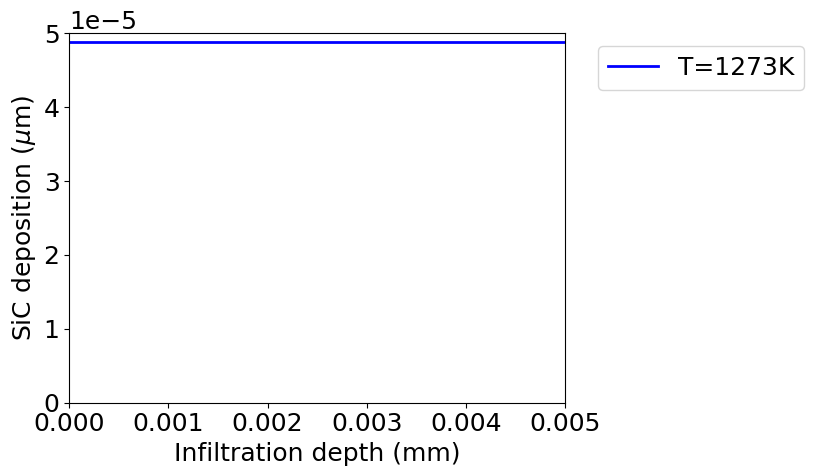

In [3]:
#
# Call the function cvi_sim
#

# Inputs: Temperature (K), pressure (Pa), pore diameter (m), aspect ratio, porosity,      ...
#         plot line color, plot line label, dt, variable to be plotted between "rp" or "C".




cvi_sim(1273,20000,100e-6, 100, 10, "blue","T=1273K",10000000,"rp")
# cvi_sim(1373,20000,100e-6, 100, 10, "red","T=1373K",1000000,"C")